In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import  r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor




In [2]:

data_1910 = pd.read_parquet("../data/modelling/works_modelling_1910s.parquet")
data_1920 = pd.read_parquet("../data/modelling/works_modelling_1920s.parquet")
data_1930 = pd.read_parquet("../data/modelling/works_modelling_1930s.parquet")
data_1940 = pd.read_parquet("../data/modelling/works_modelling_1940s.parquet")
data_1950 = pd.read_parquet("../data/modelling/works_modelling_1950s.parquet")
data_1960 = pd.read_parquet("../data/modelling/works_modelling_1960s.parquet")
data_1970 = pd.read_parquet("../data/modelling/works_modelling_1970s.parquet")
data_1980 = pd.read_parquet("../data/modelling/works_modelling_1980s.parquet")
data_1990 = pd.read_parquet("../data/modelling/works_modelling_1990s.parquet")
data_2000 = pd.read_parquet("../data/modelling/works_modelling_2000s.parquet")
data_2010 = pd.read_parquet("../data/modelling/works_modelling_2010s.parquet")
data_2020 = pd.read_parquet("../data/modelling/works_modelling_2020s.parquet")

data_gen = pd.read_parquet("../data/modelling/works_modelling.parquet")

In [3]:
data = data_gen

data["isintop"] = data["mncs"] > data["mncs"].quantile(0.9)
data["isgood"] = data["mncs"] > data["mncs"].median()

In [4]:
X = data.drop(columns=["mncs", "isintop"])
y = data["mncs"]
numeric_features = [
    "mean_past_contributions_authors",
    "mean_past_contributions_institutions",
    "past_contributions_topic",
    "mean_past_mncs_authors",
    "mean_past_mncs_institutions",
    "mean_past_mncs_topic",
    "authors_count",
    "countries_distinct_count",
    "referenced_works_count",
    "institutions_distinct_count",
    "year"
]

In [5]:
categorical_features = [
    "review",
    "meta_analysis"
]

categorical_features2 = []

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
categorical_transformer= Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown='ignore'))
])
preprocessing = ColumnTransformer([
    ("numeric", numeric_transformer, numeric_features),
    ("categorical_features", categorical_transformer, categorical_features2)
] )

In [6]:
pipeline_linear = Pipeline(steps=[
    ("preprocessing", preprocessing),
    ("regressor", LinearRegression())
])
pipeline_linear.fit(X=X,y=y)
y_pred = pipeline_linear.predict(X=X)
print(f"R2: {r2_score(y_pred = y_pred, y_true = y)}")
print(f"RMSE: {root_mean_squared_error(y_pred = y_pred, y_true = y)}")

R2: 0.15271999187062557
RMSE: 2.3982792951804095


In [7]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)
mean_r2_cv = cross_val_score(pipeline_linear, X=X, y=y, cv=cv , scoring="r2").mean()
mean_rmse_cv = -cross_val_score(pipeline_linear, X=X, y=y, cv=cv, scoring="neg_root_mean_squared_error").mean()
print(f"R2: {mean_r2_cv}")
print(f"RMSE: {mean_rmse_cv}")

R2: 0.1475738688131348
RMSE: 2.379214447941414


In [8]:
n_features = 6
model = LinearRegression()
pipeline_linear_rfe = Pipeline(steps=[
    ("preprocessing", preprocessing),
    ("feature_selection", RFE(model, n_features_to_select=n_features)),
    ("model", model)
])
mean_r2_cv = cross_val_score(pipeline_linear_rfe, X=X, y=y, cv=cv, scoring="r2").mean()
mean_rmse_cv = -cross_val_score(pipeline_linear_rfe, X=X, y=y, cv=cv, scoring="neg_root_mean_squared_error").mean()
mean_r2_cv = cross_val_score(pipeline_linear_rfe, X=X, y=y, cv=cv, scoring="r2").mean()
mean_rmse_cv = -cross_val_score(pipeline_linear_rfe, X=X, y=y, cv=cv, scoring="neg_root_mean_squared_error").mean()
print(f"R2: {mean_r2_cv}")
print(f"RMSE: {mean_rmse_cv}")

R2: 0.14709538370316083
RMSE: 2.3798123852021216


In [9]:
pipeline_linear_rfe.fit(X=X, y=y)
rfe_step = pipeline_linear_rfe.named_steps['feature_selection']
feature_names = pipeline_linear_rfe.named_steps['preprocessing'].get_feature_names_out()

ranking_features = pd.DataFrame({
    'feature': feature_names,
    'ranking': rfe_step.ranking_,
    'selected': rfe_step.support_
}).sort_values('ranking')

print(ranking_features)

                                          feature  ranking  selected
3                 numeric__mean_past_mncs_authors        1      True
7               numeric__countries_distinct_count        1      True
6                          numeric__authors_count        1      True
4            numeric__mean_past_mncs_institutions        1      True
10                                  numeric__year        1      True
8                 numeric__referenced_works_count        1      True
0        numeric__mean_past_contributions_authors        2     False
9            numeric__institutions_distinct_count        3     False
2               numeric__past_contributions_topic        4     False
5                   numeric__mean_past_mncs_topic        5     False
1   numeric__mean_past_contributions_institutions        6     False


In [10]:
model = ElasticNet()

pipeline_elasticnet = Pipeline(steps=[
    ("preprocessing", preprocessing),
    ("model", model)
])

param_grid = {
    "model__alpha": np.logspace(-2, 3, 2),
    "model__l1_ratio": np.linspace(0, 1, 2)
}

inner_cv = KFold(n_splits=3, shuffle=True, random_state=1) #validation (tuning)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=2) #test

tuned_model = GridSearchCV(pipeline_elasticnet, param_grid, cv=inner_cv, scoring="neg_mean_squared_error", n_jobs=-1)

mse = - cross_val_score(tuned_model, X, y, cv=outer_cv, scoring="neg_mean_squared_error").mean()
r2 = cross_val_score(tuned_model, X,y , cv=outer_cv, scoring="r2").mean()

C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.405e+06, tolerance: 3.333e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.240e+06, tolerance: 2.959e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of th

In [11]:
model = ElasticNetCV(cv=5, l1_ratio=[0.1,0.5,0.9], alphas=[0.01, 0.1, 1])
pipeline_elasticnet_cv = Pipeline(steps=[
    ("preprocessing", preprocessing),
    ("model", model)
])
mean_r2_cv = cross_val_score(pipeline_elasticnet_cv, X=X, y=y, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring="r2").mean()
mean_rmse_cv = -cross_val_score(pipeline_elasticnet_cv, X=X, y=y, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring="neg_root_mean_squared_error").mean()
print(f"R2: {mean_r2_cv}")
print(f"RMSE: {mean_rmse_cv}")

R2: 0.1369355888949671
RMSE: 2.403516162640865


In [12]:
numeric_data = data[numeric_features]
pca = sklearn.decomposition.PCA()

pipeline_pca = Pipeline(steps=[
    ("preprocessing", numeric_transformer),
    ("pca", pca)
])

pipeline_pca.fit(numeric_data)
data_pca = pd.DataFrame(pipeline_pca.transform(numeric_data))
data_pca["isintop"] = data["isintop"]
data_pca["isgood"] = data["isgood"]
pca_step = pipeline_pca.named_steps['pca']

components = pca_step.components_
features = numeric_data.columns

cos2 = components.T ** 2  
cos2_df = pd.DataFrame(cos2, index=features, columns=[f'PC{i+1}' for i in range(pca_step.n_components_)])

contrib = (components.T ** 2) * 100
for i in range(contrib.shape[1]):
    total = contrib[:, i].sum()
    contrib[:, i] = contrib[:, i] / total * 100

contrib_df = pd.DataFrame(contrib, index=features, columns=[f'PC{i+1}' for i in range(pca_step.n_components_)])
contrib_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
mean_past_contributions_authors,0.030543,0.329796,1.202960,85.841921,1.874591,9.557953,0.069329,0.165853,0.573090,0.353813,1.517086e-04
mean_past_contributions_institutions,5.337680,7.601318,0.106449,2.979544,48.945287,5.886997,15.813940,0.545231,11.237319,1.546235,4.638891e-07
past_contributions_topic,10.264722,15.934694,0.003751,0.071513,0.508662,0.475585,45.243921,8.933656,7.661619,10.892608,9.268162e-03
mean_past_mncs_authors,0.062025,2.347434,38.044378,4.892105,0.011028,21.797214,8.009571,24.272719,0.553787,0.007553,2.186478e-03
mean_past_mncs_institutions,0.698653,1.064516,45.882956,0.541841,0.309268,1.050632,7.652488,42.265611,0.479372,0.054647,1.640386e-05
mean_past_mncs_topic,3.800912,15.508828,0.013437,0.415334,40.455227,6.721707,22.743713,3.074893,0.013373,7.252573,2.790611e-06
authors_count,19.382135,4.076693,2.018989,0.028748,2.097895,2.944283,0.037478,2.877439,45.109204,7.203150,1.422399e+01
countries_distinct_count,13.396291,22.264744,1.097756,0.035064,3.818711,0.437978,0.067035,1.357871,30.905635,1.203350,2.541557e+01
referenced_works_count,6.785676,1.711241,10.017427,5.148021,1.600343,50.971382,0.016056,16.453120,0.737586,6.524129,3.501841e-02
institutions_distinct_count,20.859856,16.375532,1.569861,0.030661,0.281318,0.059819,0.109982,0.009245,0.076627,0.315723,6.031138e+01


In [13]:
cos2_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
mean_past_contributions_authors,0.000305,0.003298,0.012030,0.858419,0.018746,0.095580,0.000693,0.001659,0.005731,0.003538,1.517086e-06
mean_past_contributions_institutions,0.053377,0.076013,0.001064,0.029795,0.489453,0.058870,0.158139,0.005452,0.112373,0.015462,4.638891e-09
past_contributions_topic,0.102647,0.159347,0.000038,0.000715,0.005087,0.004756,0.452439,0.089337,0.076616,0.108926,9.268162e-05
mean_past_mncs_authors,0.000620,0.023474,0.380444,0.048921,0.000110,0.217972,0.080096,0.242727,0.005538,0.000076,2.186478e-05
mean_past_mncs_institutions,0.006987,0.010645,0.458830,0.005418,0.003093,0.010506,0.076525,0.422656,0.004794,0.000546,1.640386e-07
mean_past_mncs_topic,0.038009,0.155088,0.000134,0.004153,0.404552,0.067217,0.227437,0.030749,0.000134,0.072526,2.790611e-08
authors_count,0.193821,0.040767,0.020190,0.000287,0.020979,0.029443,0.000375,0.028774,0.451092,0.072031,1.422399e-01
countries_distinct_count,0.133963,0.222647,0.010978,0.000351,0.038187,0.004380,0.000670,0.013579,0.309056,0.012033,2.541557e-01
referenced_works_count,0.067857,0.017112,0.100174,0.051480,0.016003,0.509714,0.000161,0.164531,0.007376,0.065241,3.501841e-04
institutions_distinct_count,0.208599,0.163755,0.015699,0.000307,0.002813,0.000598,0.001100,0.000092,0.000766,0.003157,6.031138e-01


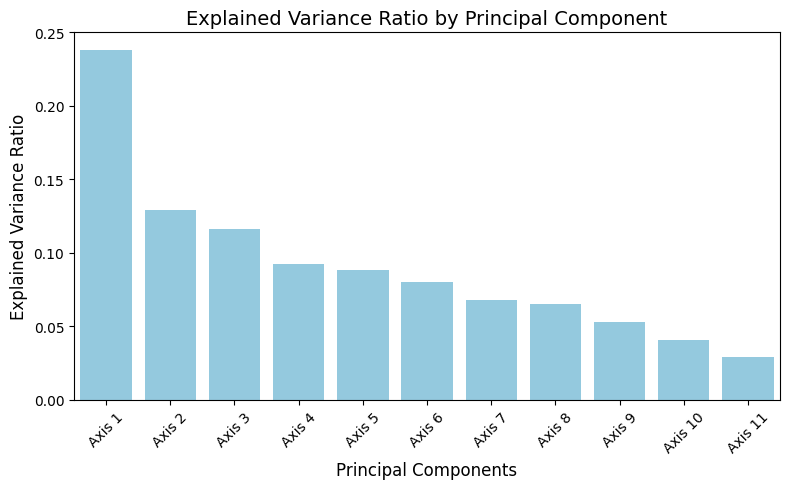

In [14]:
plt.figure(figsize=(8, 5))
sns.barplot(
    x=[f"Axis {i+1}" for i in range(len(pca_step.explained_variance_ratio_))],
    y=pca_step.explained_variance_ratio_,
    color="skyblue"
)

plt.title("Explained Variance Ratio by Principal Component", fontsize=14)
plt.xlabel("Principal Components", fontsize=12)
plt.ylabel("Explained Variance Ratio", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

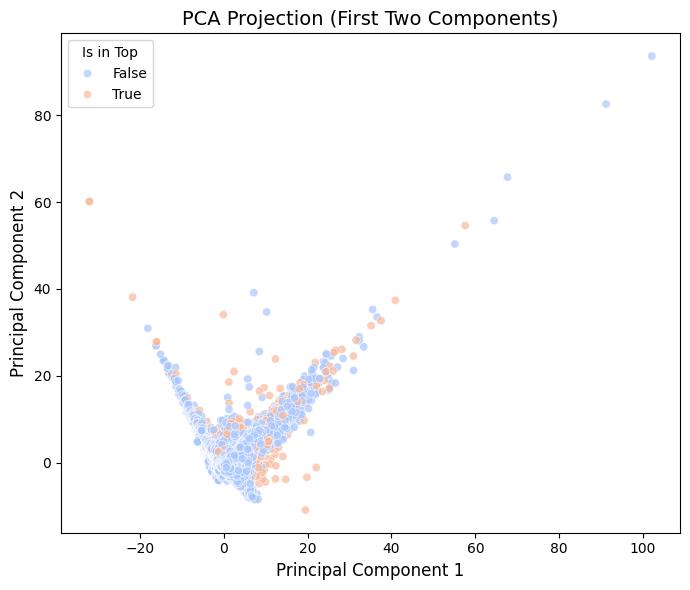

In [15]:
plt.figure(figsize=(7, 6))
sns.scatterplot(
    x=data_pca.iloc[:, 0],
    y=data_pca.iloc[:, 1],
    hue=data_pca["isintop"],
    palette="coolwarm",
    alpha=0.7
)

plt.title("PCA Projection (First Two Components)", fontsize=14)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.legend(title="Is in Top", loc="best")
plt.tight_layout()
plt.show()


Accuracy: 0.8993623107676061
Precision:0.3333333333333333
Recall: 0.0034133641886028346
F1: 0.006757530637956706


Text(0.5, 1.0, 'dataset')

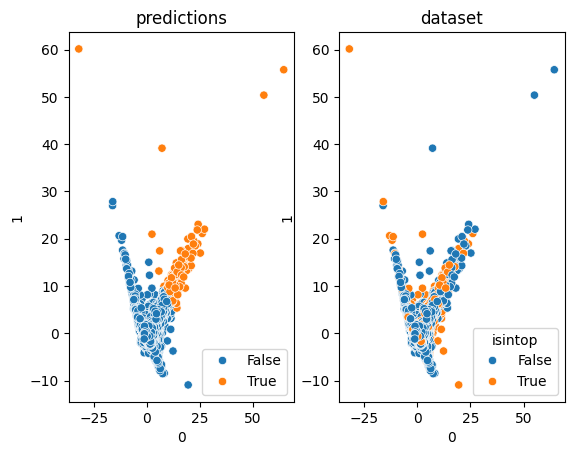

In [16]:
train, test = sklearn.model_selection.train_test_split(data_pca)

logistic = sklearn.linear_model.LogisticRegression()
pipeline_logistic = Pipeline(steps=[
    ("preprocessing", numeric_transformer),
    ("model", logistic)
])

pipeline_logistic.fit(X = train.iloc[:,:2], y = train["isintop"])
y_pred = pipeline_logistic.predict(test.iloc[:,:2])
y_true = test["isintop"]
f1 = sklearn.metrics.f1_score(y_true, y_pred)
accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred)
recall = sklearn.metrics.recall_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Precision:{precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

fig, axes = plt.subplot_mosaic([["A","B"]])
sns.scatterplot(x = test.iloc[:,0], y = test.iloc[:,1], hue=y_pred, ax = axes["A"])
sns.scatterplot(x = test.iloc[:,0], y = test.iloc[:,1], hue=y_true, ax = axes["B"])
axes["A"].set_title("predictions")
axes["B"].set_title("dataset")

Accuracy: 0.6820564369726754
Precision: 0.7156648741903286
Recall: 0.6820272754759518
F1: 0.6624196900887992


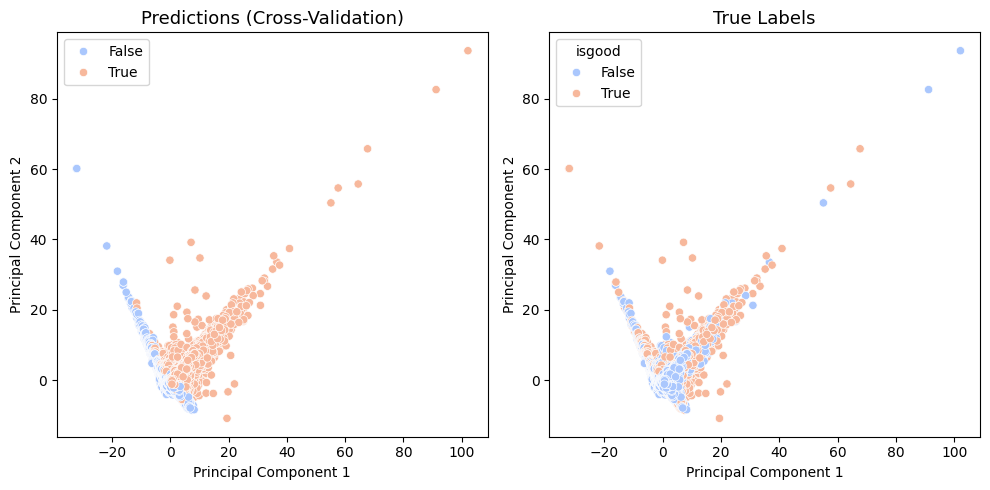

In [ ]:
from sklearn.model_selection import cross_val_predict


# Perform cross-validation
scores = {}
for i in ["accuracy", "precision_macro", "recall_macro", "f1_macro"]:
    score = sklearn.model_selection.cross_val_score(
        pipeline_logistic,
        X=data_pca.iloc[:, :3],
        y=data_pca["isgood"],
        scoring=i
    )
    scores[i] = score.mean()

print(f"Accuracy: {scores['accuracy']}")
print(f"Precision: {scores['precision_macro']}")
print(f"Recall: {scores['recall_macro']}")
print(f"F1: {scores['f1_macro']}")

y_pred = cross_val_predict(
    pipeline_logistic,
    X=data_pca.iloc[:, :3],
    y=data_pca["isgood"],
    cv=5
)

fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=(10, 5))

sns.scatterplot(
    x=data_pca.iloc[:, 0],
    y=data_pca.iloc[:, 1],
    hue=y_pred,
    palette="coolwarm",
    ax=axes["A"]
)
axes["A"].set_title("Predictions (Cross-Validation)", fontsize=13)
axes["A"].set_xlabel("Principal Component 1")
axes["A"].set_ylabel("Principal Component 2")

sns.scatterplot(
    x=data_pca.iloc[:, 0],
    y=data_pca.iloc[:, 1],
    hue=data_pca["isgood"],
    palette="coolwarm",
    ax=axes["B"]
)
axes["B"].set_title("True Labels", fontsize=13)
axes["B"].set_xlabel("Principal Component 1")
axes["B"].set_ylabel("Principal Component 2")

plt.tight_layout()
plt.show()


In [18]:
y10 = data["isintop"]
y50 = data["isgood"]
X = data.drop(columns=["mncs", "isintop", "isgood"])
X_rfe = data[["mean_past_mncs_authors", "mean_past_mncs_institutions", "mean_past_mncs_topic", "referenced_works_count", "review", "meta_analysis"]]

In [19]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


param_grid = {
    'model__n_estimators': [100, 80],
    'model__learning_rate': [0.04, 0.05],
    'model__max_depth': [1, 2],
    'model__subsample': [0.5, 0.6]
}

gradient_boosting = XGBClassifier(random_state=1)
pipeline_gradient_boosting = Pipeline(steps=[
    ("preprocessing", preprocessing),  
    ("model", gradient_boosting)
])

grid = GridSearchCV(pipeline_gradient_boosting, param_grid, cv=5)
grid.fit(X=X, y=y50)
print("Best hyperparameters:", grid.best_params_)


scoring = ["f1_macro", "precision_macro", "recall_macro", "accuracy"]
cv_results = cross_validate(grid, X=X, y=y50, cv=5, scoring=scoring)

print(f"f1: {cv_results['test_f1_macro'].mean()}")
print(f"precision: {cv_results['test_precision_macro'].mean()}")
print(f"recall: {cv_results['test_recall_macro'].mean()}")
print(f"accuracy: {cv_results['test_accuracy'].mean()}")

y_pred = cross_val_predict(grid.best_estimator_, X=X, y=y50, cv=5)



Best hyperparameters: {'model__learning_rate': 0.04, 'model__max_depth': 1, 'model__n_estimators': 100, 'model__subsample': 0.5}
f1: 0.7039615777222397
precision: 0.7589104024216258
recall: 0.7178241383498738
accuracy: 0.7177793295413664


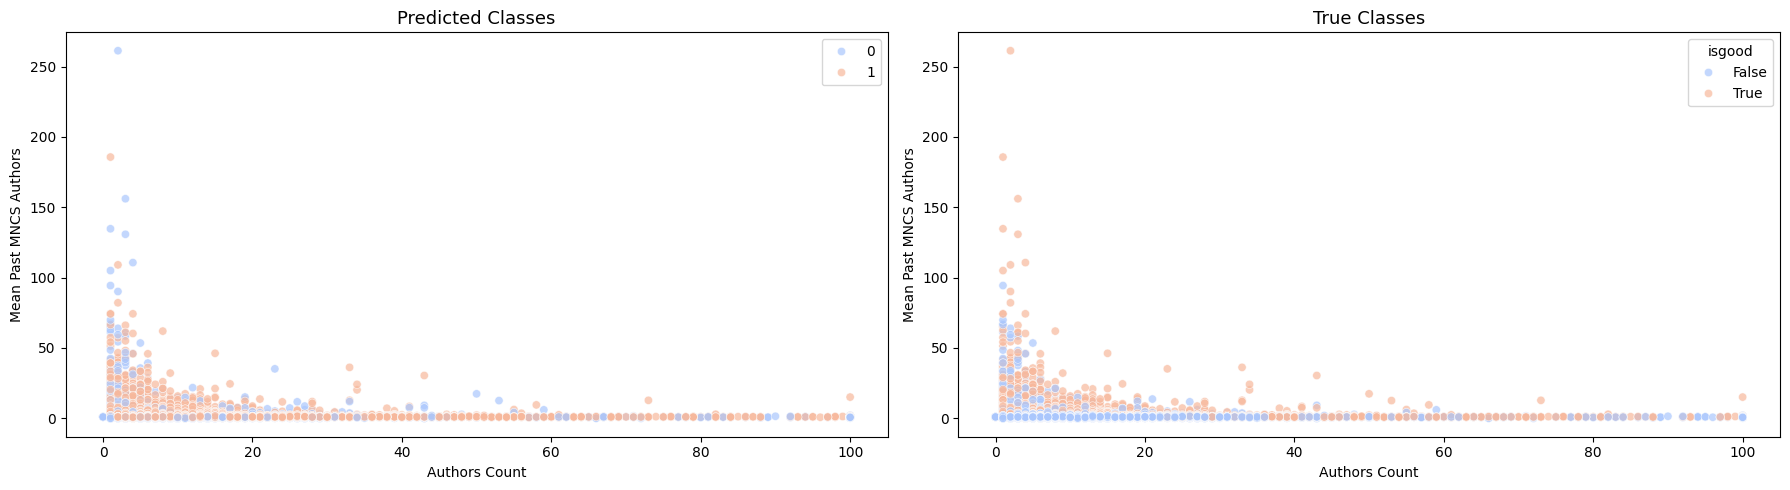

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))

sns.scatterplot(
    x=X["authors_count"],
    y=X["mean_past_mncs_authors"],
    hue=y_pred,
    palette="coolwarm",
    alpha=0.7,
    ax=axes[0],
)
axes[0].set_title("Predicted Classes", fontsize=13)
axes[0].set_xlabel("Authors Count")
axes[0].set_ylabel("Mean Past MNCS Authors")

sns.scatterplot(
    x=X["authors_count"],
    y=X["mean_past_mncs_authors"],
    hue=y50,
    palette="coolwarm",
    alpha=0.7,
    ax=axes[1],
)
axes[1].set_title("True Classes", fontsize=13)
axes[1].set_xlabel("Authors Count")
axes[1].set_ylabel("Mean Past MNCS Authors")

"""
best_model = grid.best_estimator_.named_steps["model"]
importances = best_model.feature_importances_

sns.barplot(
    x=importances,
    y=X.columns,
    palette="viridis",
    ax=axes[2]
)
axes[2].set_title("Feature Importance - XGBoost", fontsize=13)
axes[2].set_xlabel("Importance")
axes[2].set_ylabel("Features")
"""
plt.tight_layout()
plt.show()

In [32]:
print(X.shape)
print(len(y50))
print(len(y_pred))


(689361, 15)
689361
689361


In [33]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__bootstrap': [True]
}

random_forest = RandomForestClassifier(
    random_state=1,
    class_weight="balanced",
    n_jobs=-1
)

pipeline_random_forest = Pipeline(steps=[
    ("preprocessing", preprocessing),
    ("model", random_forest)
])

grid = GridSearchCV(pipeline_random_forest, param_grid, cv=3)
grid.fit(X=X, y=y10)
print("Best hyperparameters:", grid.best_params_)



scoring = ["f1_macro", "precision_macro", "recall_macro", "accuracy"]
cv_results = cross_validate(grid, X=X, y=y10, cv=3, scoring=scoring)

print(f"f1: {cv_results['test_f1_macro'].mean():.3f}")
print(f"precision: {cv_results['test_precision_macro'].mean():.3f}")
print(f"recall: {cv_results['test_recall_macro'].mean():.3f}")
print(f"accuracy: {cv_results['test_accuracy'].mean():.3f}")


y_pred = cross_val_predict(grid.best_estimator_, X=X, y=y10, cv=3)



Best hyperparameters: {'model__bootstrap': True, 'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 50}
f1: 0.365
precision: 0.680
recall: 0.535
accuracy: 0.565


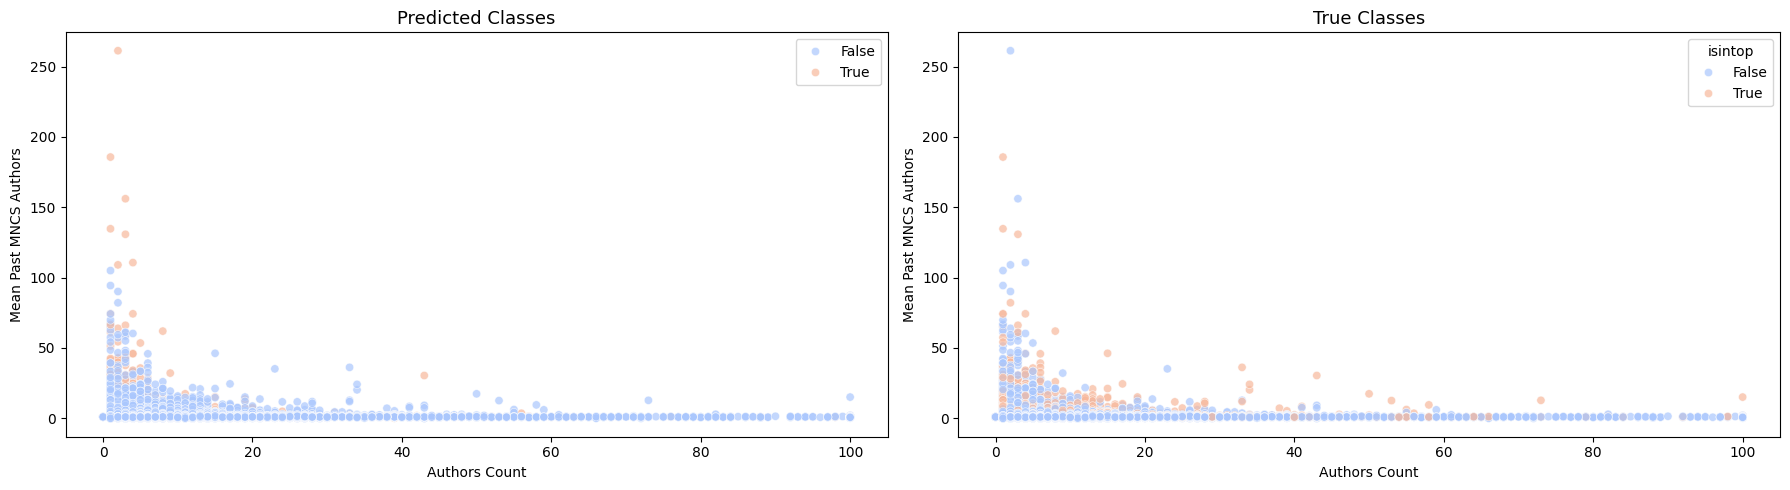

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))

sns.scatterplot(
    x=X["authors_count"],
    y=X["mean_past_mncs_authors"],
    hue=y_pred,
    palette="coolwarm",
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title("Predicted Classes", fontsize=13)
axes[0].set_xlabel("Authors Count")
axes[0].set_ylabel("Mean Past MNCS Authors")

sns.scatterplot(
    x=X["authors_count"],
    y=X["mean_past_mncs_authors"],
    hue=y10,
    palette="coolwarm",
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title("True Classes", fontsize=13)
axes[1].set_xlabel("Authors Count")
axes[1].set_ylabel("Mean Past MNCS Authors")

"""
best_model = grid.best_estimator_.named_steps["model"]
importances = best_model.feature_importances_
features = X.columns

sns.barplot(
    x=importances,
    y=features,
    palette="viridis",
    ax=axes[2]
)
axes[2].set_title("Feature Importance - Random Forest", fontsize=13)
axes[2].set_xlabel("Importance")
axes[2].set_ylabel("Features")
"""
plt.tight_layout()
plt.show()


In [35]:
y10 = data["isintop"]
y50 = data["isgood"]
X = data.drop(columns=["mncs", "isintop", "isgood"])
X_rfe = data[["mean_past_mncs_authors", "mean_past_mncs_institutions", "mean_past_mncs_topic", "referenced_works_count", "review", "meta_analysis"]]
pipeline_logistic = Pipeline(steps=[
    ("preprocessing", preprocessing),
    ("model", logistic)
])

scores = {}
for i in ["accuracy", "precision_macro", "recall_macro", "f1_macro"]:
    score = sklearn.model_selection.cross_val_score(pipeline_logistic,
                                                    X=X,
                                                    y=y50,
                                                    scoring=i)
    scores[i] = score.mean()
print(f"Accuracy: {scores['accuracy']}")
print(f"Precision:{scores['precision_macro']}")
print(f"Recall: {scores['recall_macro']}")
print(f"F1: {scores['f1_macro']}")

Accuracy: 0.7032919967154863
Precision:0.7188376434013886
Recall: 0.7032815548364022
F1: 0.6961202390706168


In [36]:


X_train, X_test, y_train, y_test = train_test_split(
    X[numeric_features],
    y,
    test_size=0.2,
    random_state=42
)

rf = RandomForestRegressor(n_estimators=50, random_state=42,   n_jobs=-1)
rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)

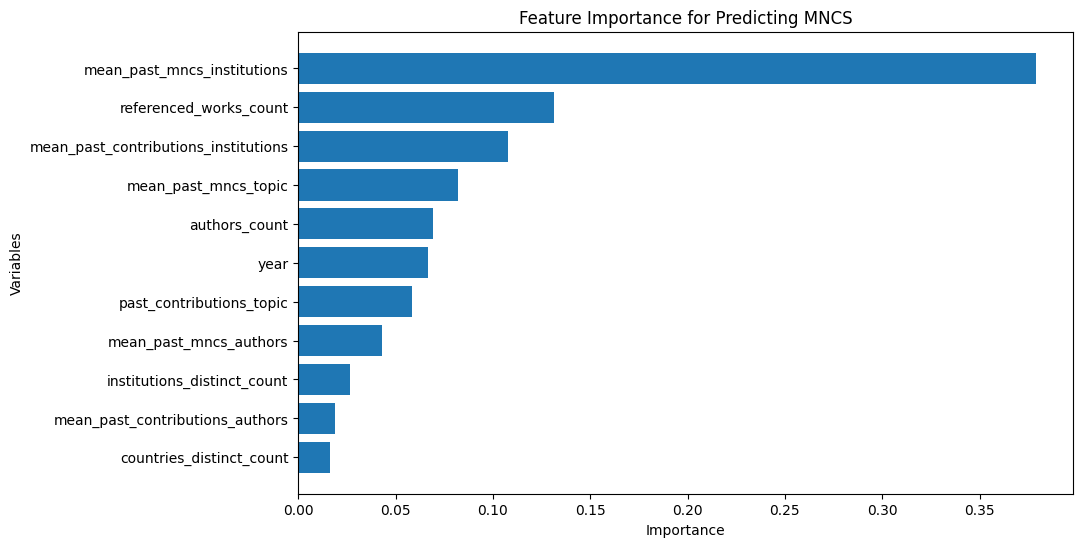

In [37]:
importances = pd.DataFrame({
    "variable": numeric_features,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(importances["variable"], importances["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance for Predicting MNCS")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.show()


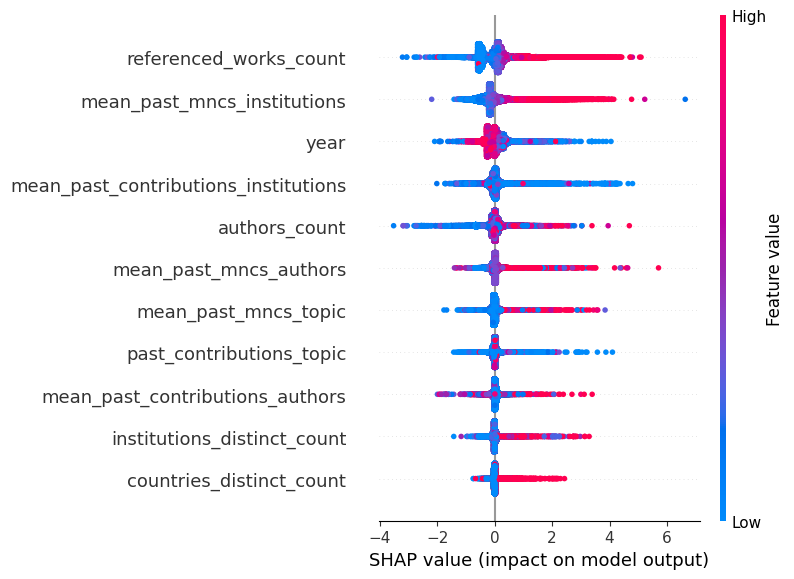

In [38]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test, approximate=True)

if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values  

shap_magnitude = np.abs(shap_values_to_plot).sum(axis=1)
mask = shap_magnitude < np.percentile(shap_magnitude, 99)  
shap_values_filtered = shap_values_to_plot[mask]
X_filtered = X_test.iloc[mask]

shap.summary_plot(shap_values_filtered, X_filtered)
